# Template fits

In applications we are interested in separating a signal component from background components, we often fit parameteric models to data. Sometimes constructing a parametric model for some component is difficult. In that case, one fits a template instead which may be obtained from simulation or from a calibration sample in which a pure component can be isolated.

The challenge then is to propagate the uncertainty of the template into the result. The template is now also estimated from a sample (be it simulated or a calibration sample), and the uncertainty associated to that can be substantial. We investigate different approaches for template fits, including the Barlow-Beeston and Barlow-Beeston-lite methods.

In [1]:
from iminuit import Minuit
from iminuit.cost import poisson_chi2, BarlowBeestonLite
import numpy as np
from scipy.stats import norm, truncexpon
from scipy.optimize import root_scalar, minimize
import matplotlib.pyplot as plt
from IPython.display import display
from collections import defaultdict
from joblib import Parallel, delayed

As a toy example, we generate a mixture of two components: a normally distributed signal and exponentially distributed background.

In [2]:
rng = np.random.default_rng(1)

def generate(rng, ndata, nmc, fsig, bins):
    n = rng.poisson(ndata)
    b = truncexpon(1, 0, 2).rvs(size=int((1-fsig) * n), random_state=rng)
    s = norm.rvs(1, 0.1, size=int(fsig * n), random_state=rng)
    x = np.append(b, s)

    w, xe = np.histogram(x, bins=bins, range=(0, 2))

    n = rng.poisson(nmc)
    b_mc = truncexpon(1, 0, 2).rvs(size=n, random_state=rng)
    s_mc = norm.rvs(1, 0.1, size=n, random_state=rng)

    w_mc = np.array([
        np.histogram(b_mc, bins=bins, range=(0, 2))[0],
        np.histogram(s_mc, bins=bins, range=(0, 2))[0],
    ])

    return xe, w, w_mc

xe, w, w_mc = generate(rng, 1000, 100, 0.25, 15)

Data is visualized on the left-hand side. The templates are shown on the right-hand side. To show the effect of uncertainties in the template, this example intentially uses templates with poor statistical resolution.

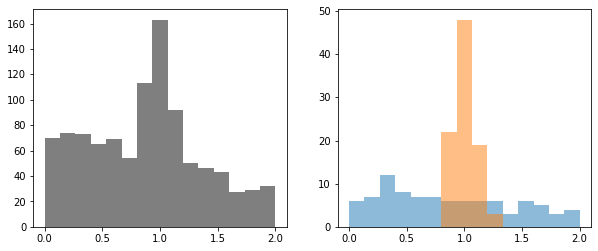

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].stairs(w, xe, fill=True, color="k", alpha=0.5, label="data")
for i, wi in enumerate(w_mc):
    ax[1].stairs(wi, xe, fill=True, alpha=0.5, label=f"template {i}")

## Bootstrapping template uncertainties

We perform a standard fit and pretend that the templates have no uncertainties. Then we repeat this fit many times with templates that are fluctuated around the actual values assuming a Poisson distribution. This is a common general method of uncertainty propagation which is backed up by bootstrap theory.

There is no builtin cost function in iminuit for a template fit, so we write the cost function for this case.

In [4]:
def cost(yields):
    mu = 0
    for y, c in zip(yields, w_mc):
        mu += y * c / np.sum(c)
    r = poisson_chi2(w, mu)
    return r

cost.errordef = Minuit.LEAST_SQUARES
cost.ndata = np.prod(w.shape)

starts = np.ones(2)
m = Minuit(cost, starts)
m.limits = (0, None)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.84 (chi2/ndof = 3.4)    │              Nfcn = 120              │
│ EDM = 6.26e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    780    │    31     │            │            │    0    │         │       │
│ 1 │ x1   │    220    │    20     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────┐
│    │   x0   x1 │
├────┼───────────┤
│ x0 │  975 -195 │
│ x1 │ -195  415 │
└────┴───────────┘

The uncertainties reported by the fit correspond to the uncertainty in the data, but not the uncertainty in the templates. The chi2/ndof is also very large, since the uncertainties in the template are not considered in the fit.

We bootstrap the templates 1000 times and compute the covariance of the fitted results.

In [5]:
b = 1000
rng = np.random.default_rng(1)
pars = []
for ib in range(b):
    w_mc_i = rng.poisson(w_mc)

    def cost(yields):
        mu = 0
        for y, c in zip(yields, w_mc_i):
            mu += y * c / np.sum(c)
        r = poisson_chi2(w, mu)
        return r
    
    mi = Minuit(cost, m.values[:])
    mi.errordef = Minuit.LEAST_SQUARES
    mi.limits = (0, None)
    mi.strategy = 0
    mi.migrad()
    assert mi.valid
    pars.append(mi.values[:])

cov2 = np.cov(np.transpose(pars), ddof=1)

We print the uncertainties from the different stages and the correlation between the two yields.

To obtain the full error, we add the independent covariance matrices from the original fit and the bootstrap.

In [6]:
cov1 = m.covariance

for title, cov in zip(("fit", "bootstrap", "fit+bootstrap"), 
                      (cov1, cov2, cov1 + cov2)):
    print(title)
    for label, p, e in zip(("b", "s"), m.values, np.diag(cov) ** 0.5):
        print(f"  {label} {p:.0f} +- {e:.0f}")
    print(f"  correlation {cov[0, 1] / np.prod(np.diag(cov)) ** 0.5:.2f}")

fit
  b 780 +- 31
  s 220 +- 20
  correlation -0.31
bootstrap
  b 780 +- 43
  s 220 +- 39
  correlation -0.93
fit+bootstrap
  b 780 +- 53
  s 220 +- 44
  correlation -0.75


The bootstrapped template errors are much larger than the fit errors in this case, since the sample used to generate the templates is much smaller than the data sample.

The bootstrapped errors for both yields are nearly equal (they become exactly equal if the template sample is large) and the correlation is close to -1 (and becomes exactly -1 in large samples). This is expected, since the data sample is fixed in each iteration. Under these conditions, a change in the templates can only increase the yield of one component at an equal loss for the other component.

## Template fit with nuisance parameters

As described in [Barlow and Beeston, Comput.Phys.Commun. 77 (1993) 219-228](https://doi.org/10.1016/0010-4655(93)90005-W), the correct treatment from first principles is to write down the likelihood function for this case, in which the observed values and unknown parameters are clearly stated. The insight is that the true contents of the bins for the templates are unknown and we need to introduce a nuisance parameter for each bin entry in the template. The combined likelihood for the problem is then combines the estimation of the template yields with the estimation of unknown templates.

This problem can be handled straight-forwardly with Minuit, but it leads to the introduction of a large number of nuisance parameters, one for each entry in each template. We again write a cost function (here a class for convenience).

As a technical detail, it is necessary to increase the call limit in Migrad for the fit to fully converge, since the limit set by Minuit's default heuristic is too tight for this application.

In [7]:
class BB:
    def __init__(self, w, w_mc):
        self.data = w, w_mc

    def __call__(self, par):
        w, w_mc = self.data
        bins = len(w)
        yields = par[:2]
        nuisances = par[2:]
        b = nuisances[:bins]
        s = nuisances[bins:]
        mu = 0
        for y, c in zip(yields, (b, s)):
            mu += y * c / np.sum(c)
        r = poisson_chi2(w, mu) + poisson_chi2(w_mc[0], b) + poisson_chi2(w_mc[1], s)
        return r

    errordef = Minuit.LEAST_SQUARES

    @property
    def ndata(self):
        w, w_mc = self.data
        return np.prod(w.shape) + np.prod(w_mc.shape)

m1 = Minuit(BB(w, w_mc), np.concatenate([(750, 250), w_mc[0], w_mc[1]]))
m1.limits = (0, None)
m1.migrad(ncall=100000)
m1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.676 (chi2/ndof = 0.4)    │             Nfcn = 2453              │
│ EDM = 0.000175 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    780    │    50     │            │            │    0    │         │       │
│ 1 │ x1   │    220    │    40     │            │            │    0    │         │       │
│ 2 │ x2   │    8.0    │    1.3    │            │            │    0    │         │       │
│ 3 │ x3   │    8.5    │    1.3    │            │            │    0    │         │       │
│ 4 │ x4   │    9.0    │    1.4    │            │            │    0    │         │       │
│ 5 │ x5   │    7.7    │    1.2    │            │            │    0    │         │       │
│ 6 │ x6   │    8.0    │    1.3    │            │            │    0    │         │       │
│ 7 │ x7   │    6.4    │    1.1    │            │            │    0    │         │       │
│ 8 │ x8   │    6.8    │    1.8    │            │            │    0    │         │       │
│ 9 │ x9   │    5.9    │    2.2    │            │            │    0    │         │       │
│ 10│ x10  │    5.7    │    1.5    │            │            │    0    │         │       │
│ 11│ x11  │    5.2    │    1.0    │            │            │    0    │         │       │
│ 12│ x12  │    5.2    │    0.9    │            │            │    0    │         │       │
│ 13│ x13  │    5.2    │    0.9    │            │            │    0    │         │       │
│ 14│ x14  │    3.4    │    0.7    │            │            │    0    │         │       │
│ 15│ x15  │    3.4    │    0.7    │            │            │    0    │         │       │
│ 16│ x16  │    3.8    │    0.8    │            │            │    0    │         │       │
│ 17│ x17  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 18│ x18  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 19│ x19  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 20│ x20  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 21│ x21  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 22│ x22  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 23│ x23  │    23     │     4     │            │            │    0    │         │       │
│ 24│ x24  │    48     │     7     │            │            │    0    │         │       │
│ 25│ x25  │    19     │     4     │            │            │    0    │         │       │
│ 26│ x26  │    2.9    │    1.6    │            │            │    0    │         │       │
│ 27│ x27  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 28│ x28  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 29│ x29  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 30│ x30  │    0.0    │    0.4    │            │            │    0    │         │   

The result of this fit is comparable to the bootstrap method for this example, but the chi2/ndof is now reasonable and the uncertainties are correct without further work. This method should perform better than the bootstrap method, if the count per bin in the templates is small.

Another advantage is of this technique is that one can profile over the likelihood to obtain a 2D confidence regions, which is not possible with the bootstrap technique.

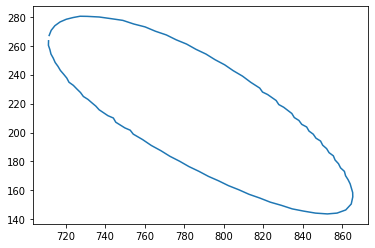

In [8]:
c1 = m1.mncontour("x0", "x1")
plt.plot(c1[:,0], c1[:, 1])

Before moving on, we briefly explore a possible refinement of the previous method, which is to hide the nuisance parameters from Minuit with a nested fit. It turns out that this technique is not an improvement, but it is useful to show that explicitly.

The idea is to construct an outer cost function, which only has the yields as parameters. Inside the outer cost function, the best nuisance parameters are found for the current yields with an inner cost function. Technically, this is achieved by calling a minimizer on the inner cost function at every call to the outer cost function.

Technical detail: It is important here to adjust Minuit's expectation of how accurate the cost function is computed. Usually, Minuit performs its internal calculations under the assumption that the cost function is accurate to machine precision. This is usually not the case when a minimizer is used internally to optimize the inner function. We perform the internal minimization with SciPy, which allows us to set the tolerance. We set it here to 1e-8, which is sufficient for this problem and saves a bit of time on the internal minimisation. We then instruct Minuit to expect only this precision.

In [9]:
precision = 1e-8

def cost(yields):
    bins = len(w)

    def inner(nuisance):
        b = nuisance[:bins]
        s = nuisance[bins:]
        mu = 0
        for y, c in zip(yields, (b, s)):
            mu += y * c / np.sum(c)
        r = poisson_chi2(w, mu) + poisson_chi2(w_mc[0], b) + poisson_chi2(w_mc[1], s)
        return r

    bounds = np.zeros((2 * bins, 2))
    bounds[:, 1] = np.inf
    r = minimize(inner, w_mc.flatten(), bounds=bounds, tol=precision)
    assert r.success
    return r.fun

cost.errordef = Minuit.LEAST_SQUARES
cost.ndata = np.prod(w.shape)

m2 = Minuit(cost, (750, 250))
m2.precision = precision
m2.limits = (0, None)
m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.676 (chi2/ndof = 0.4)    │              Nfcn = 43               │
│ EDM = 1.96e-07 (Goal: 0.0002)    │            time = 2.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    780    │    50     │            │            │    0    │         │       │
│ 1 │ x1   │    220    │    40     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  2.51e+03 -1.73e+03 │
│ x1 │ -1.73e+03  1.95e+03 │
└────┴─────────────────────┘

We obtain the exact same result as expected, but the runtime is much longer (more than a factor 10), which disfavors this technique compared to the straight-forward fit. The minimization is not as efficient, because Minuit cannot exploit correlations between the internal and the external parameters that allow it to converge it faster when it sees all parameters at once.

## Barlow-Beeston-lite

The implementation described by [Barlow and Beeston, Comput.Phys.Commun. 77 (1993) 219-228](https://doi.org/10.1016/0010-4655(93)90005-W) solves the problem similary to the nested fit described above, but the solution to the inner problem is found in a different way which is more efficient. Unfortuntely, their approach still requires numerically solving a non-linear equation per bin. The finite accuracy of the non-linear solver introduces discontinuities in the log-likelihood that confuse Minuit, as noted by [Conway, PHYSTAT 2011, https://arxiv.org/abs/1103.0354](https://doi.org/10.48550/arXiv.1103.0354). To address this, Conway proposes a simplified treatment where the uncertainty in the template is described by a multiplicative factor constrained by a Gaussian. With this simplification, the optimal nuisance parameters can be found by bin-by-bin by solving a quadratic equation which has only one allowed solution that can be found analytically. This method is implemented in the builtin BarlowBeestonLite cost function.

In [10]:
c = BarlowBeestonLite(w, xe, w_mc)
m3 = Minuit(c, 750, 250)
m3.limits = (0, None)
m3.migrad()
m3.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.734 (chi2/ndof = 0.4)    │              Nfcn = 47               │
│ EDM = 7.52e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.83e3   │  0.10e3   │            │            │    0    │         │       │
│ 1 │ x1   │    210    │    50     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │   1.1e+04 -2.05e+03 │
│ x1 │ -2.05e+03  2.62e+03 │
└────┴─────────────────────┘

In [11]:
for title, m in zip(("full fit", "Barlow-Beeston-Lite"), (m1, m3)):
    print(title)
    cov = m.covariance
    for label, p, e in zip(("x0", "x1"), m.values, np.diag(cov) ** 0.5):
        print(f"  {label} {p:.0f} +- {e:.0f}")
    print(f"  correlation {cov[0, 1] / (cov[0, 0] * cov[1, 1]) ** 0.5:.2f}")

full fit
  x0 781 +- 50
  x1 219 +- 44
  correlation -0.78
Barlow-Beeston-Lite
  x0 827 +- 105
  x1 211 +- 51
  correlation -0.38


The best yields found by the Barlow-Beeston-Lite (BBL) method differ from those found with the Barlow-Beeston (BB) method, because the two likelihoods are rather different. In this particular case, the uncertainty for the signal estimated by the BBL is larger. The difference shows up in particular in the 68 % confidence regions.

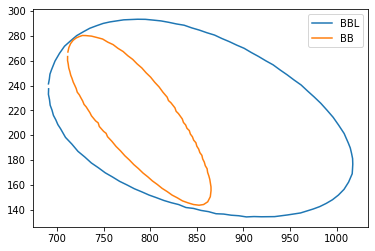

In [12]:
c3 = m3.mncontour("x0", "x1")
plt.plot(c3[:,0], c3[:, 1], label="BBL")
plt.plot(c1[:,0], c1[:, 1], label="BB")
plt.legend();

A single toy experiment cannot be used to judge the performance of these two methods. We need to study the properties of these fits applied to sets of toy experiments, which allow us to measure the bias and true variance of the estimates.

We run three sets of experiments, with increasing number of events sampled for the templates. The expectation is that the two methods agree better when the relative uncertainties in the templates are reduced.

In [16]:
@delayed
def compute(seed, ndata, nmc):
    rng = np.random.default_rng(seed)
    xe, w, w_mc = generate(rng, ndata, nmc, 0.25, 15)
    accept = True
    result = []
    for cost in (BB, BarlowBeestonLite):
        ma = False
        for w_mc_i in w_mc:
            ma |= w_mc_i > 0
        if cost is BB:
            w_mc_m = w_mc[:, ma]
            m = Minuit(cost(w[ma], w_mc_m), np.concatenate([[750, 250], *w_mc_m]))
        else:
            m = Minuit(cost(w, xe, w_mc), 750, 250)
        m.limits = (0, None)
        # try hard to converge and get correct error estimates
        for iter in range(3):
            m.strategy = 0
            m.migrad(ncall=1000000, iterate=1)
            m.hesse()
            if m.valid:
                break
        if not m.valid:
            print(cost.__name__)
            display(m)
        accept &= m.valid
        result.append((m.values[0], m.values[1], m.covariance[0, 0], m.covariance[1, 1]))
    if accept:
        return result
    return None

results = {}
for nmc in (100, 1000, 10000):
    r = Parallel(-1, verbose=1)(compute(s, 1000, nmc) for s in range(1000))
    r = [_ for _ in r if _ is not None]
    results[nmc] = np.array(r)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   39.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   14.4s
[Paral

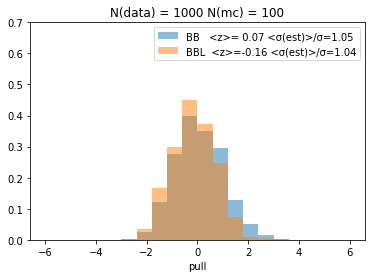

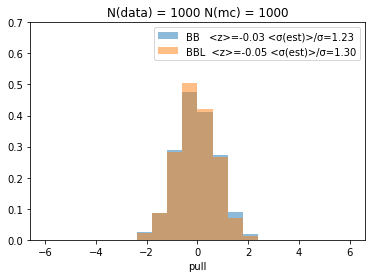

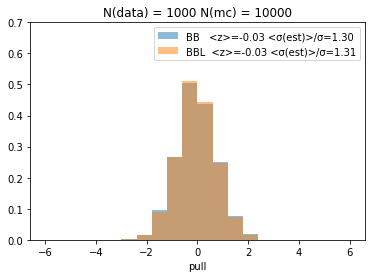

In [17]:
ndata = 1000
expected = 250
for nmc, r in results.items():
    plt.figure()
    for i, label in enumerate(("BB", "BBL")):
        s = r[:, i, 1]
        vs = r[:, i, 3]
        z = (s  - expected) / vs ** 0.5
        ma = np.abs(z) < 10
        nout = np.sum(~ma)
        if nout: # there should not be outliers
            print(label, "outliers", ndata, nmc)
            for k in np.arange(len(ma))[~ma]:
                print(f"  z = {z[k]:.1f} s = {s[k]:.1f} σ {vs[k] ** 0.5:.1f}")        
        plt.hist(z, label=f"{label:4} <z>={np.mean(z):5.2f} <σ(est)>/σ={np.mean(vs) ** 0.5 / np.std(s, ddof=1):.2f}", density=True, alpha=0.5, bins=20, range=(-6, 6))
    plt.xlabel("pull")
    plt.title(f"N(data) = {ndata} N(mc) = {nmc}")
    plt.ylim(0, 0.7)
    plt.legend();

We find that both methods have comparable performance and negligible bias. However, both fits overestimate the uncertainty by 30 % in this example.